In [81]:
import torch
from torch.autograd import Variable
from torch.nn import functional as F
import pickle
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import random
import os
from CNN import mymodel
from skimage import feature as ft
from torchvision import transforms as transforms
import cv2

In [84]:
## Reading & Preparing Image Data##

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def show_one_img(data,im_idx):
    im = data[im_idx].reshape((3,32,32))
    im = im.transpose(1,2,0)
    return im

Text(0.5, 1.0, 'cat')

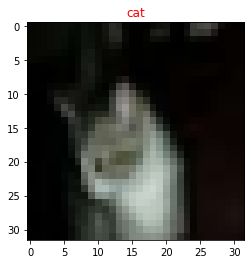

In [94]:
##Random show one pic
files = "cifar-10-python/cifar-10-batches-py"
batch_idx = random.randint(1,5)
img_idx = random.randint(0,9999)
batch = "data_batch_"+str(batch_idx)
file = os.path.join(files,batch)

batch_dict = unpickle(file)
imgs_data = batch_dict[b'data']
imgs_data = np.array(imgs_data)
imgs_label = batch_dict[b'labels']
imgs_label = np.array(imgs_label)
label_name=['airplane','automobile','brid','cat','deer','dog','frog','horse','ship','truck']

img = show_one_img(imgs_data,img_idx)
label = imgs_label[img_idx]


plt.imshow(img)
plt.title(label_name[label],color="r")


In [95]:
this_im = img
this_label = label
this_im = Image.fromarray(this_im)

myTransforms = transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

im_trans = myTransforms(this_im)


In [96]:
im_in = im_trans.unsqueeze(0)
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [97]:
model = torch.load('trans_alex.pth')
model.to(device)
im_in = im_in.to(device)
model


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4608, bias=True)
    (1): ReLU()
    (2): Linear(in_featu

In [108]:
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

def CAM(feature_conv, weight_softmax, weight_softmax2, class_idx):

    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    weight_softmax = weight_softmax.dot(weight_softmax2)
    for idx in class_idx:

        cam = weight_softmax[idx]*(feature_conv.reshape((nc*h*w)))
        cam = cam.reshape(nc, h, w)
        newcam = np.zeros((h,w))
        for i in range(nc):
            newcam = cam[i]+newcam
        newcam = newcam - np.min(newcam)
        cam_img = newcam / np.max(newcam)
        cam_img = -np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [112]:
model.eval()

features_blobs = []
model._modules.get('features').register_forward_hook(hook_feature)
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())
weight_softmax2 = np.squeeze(params[-4].data.cpu().numpy())
logit = model(im_in)
h_x = F.softmax(logit, dim=1).data.squeeze()	
print(h_x.shape)						# torch.Size([1000])
probs, idx = h_x.sort(0, True)	
probs =  probs.cpu().numpy()
idx = idx.cpu().numpy()

CAMs = CAM(features_blobs[0], weight_softmax, weight_softmax2, [idx[0]])
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(32, 32)), cv2.COLORMAP_JET)
				

torch.Size([10])


Text(0.5, 1.0, 'cat')

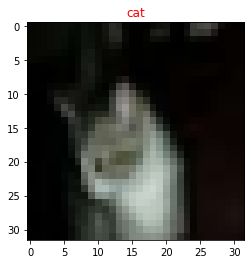

In [110]:
plt.imshow(img)
plt.title(label_name[label],color="r")

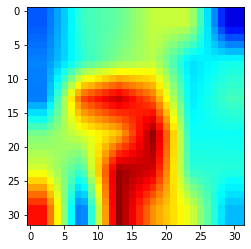

In [111]:
plt.imshow(heatmap)